---
**Method of lines and explicit euler**

Week 20 of EMAT30008

https://engmaths.github.io/emat30008/pdes/explicit/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [2]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
from typing import Literal
from scicomp.odefunctions import *

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We solve the diffusion PDE

$\frac{dx}{dt} = D \frac{d^2 u}{d x^2} + q(x,t,u:\mu) = 0$

over domain $a \leq x \leq b$, $D > 0$

------
Q1

Use explicit euler method to solve the equation when $D=1$ and $q=0$. 

Dirichlet boundary $u(a,t)=u(b,t)=0$

Initial condition: $u(x,0) = sin(\frac{\pi (x-a)}{b-a})$

We split into N+1 grid points $x_i$ and each $u_i = u(x=x_i, t)$ becomes a state variable of its own. 

We approximate the RHS space derivative using the finite difference method with relevant boundary conditions. 

TODO: Write this out on a piece of paper. Can't just call the finite_diff_bvp_solver function, but can use some of its code to construct A_matrix and b_vec for use in this. Work out how it would work with boundary conditions

We then just solve the equation, passing the RHS into our solve_to function, since we have an equation of the form 
$\frac{du}{dt} = F(x,t)$

In [10]:
# We begin by splitting our finite_diff_bvp_solver into that and a construct_A_and_b function

def bvp_construct_A_and_b(num_grid_points: int,
                          grid_bounds: list[float],
                          left_boundary_vals: list[float],
                          right_boundary_vals: list[float],
                          left_boundary_type: Literal['Dirichlet', 'Neumann', 'Robin'] = 'Dirichlet', 
                          right_boundary_type: Literal['Dirichlet', 'Neumann', 'Robin'] = 'Dirichlet',
                          ):
    '''
    Prepares the matrix A_matrix and vector b_vector for use in finite difference solving for a BVP diffusion problem.
    See finite_diff_bvp_solver function.
    
    Problems are of form:
    D (d^2u/dx2) + q(x,u:mu) = 0
    between a<=x<=b, where D is the diffusivity (scalar), and q is any source function.

    Boundary conditions (at end x=a WLOG):
    - Dirichlet: u(a) = alpha
    - Neumann: du/dx{a} = alpha
    - Robin: du/dx{a} = alpha + beta*u(a)
    where alpha is specified.

    -----
    Parameters
    -----
    num_grid_points : int
        The number of spatial x grid points used in the numerical approximation.
    grid_bounds : [a,b] where a<b are floats
        The bounds a<=x<=b of the problem.
    left_boundary_vals : [alpha, beta] where alpha,beta are floats
        The constant values used to describe the left boundary condition. Beta optional, used for Robin boundary
    right_boundary_vals : [alpha, beta] where alpha,beta are floats
        The constant values used to describe the left boundary condition. Beta optional, used for Robin boundary
    left_boundary_type : 'Dirichlet', 'Neumann', or 'Robin', default 'Dirichlet'
        The string used to specify the type of boundary condition on the left.
    right_boundary_type : 'Dirichlet', 'Neumann', or 'Robin', default 'Dirichlet'
        The string used to specify the type of boundary condition on the right.

    -----
    Returns
    -----
    A_matrix : 2-D tridiagonal matrix array
        The corresponding matrix used to specify the 2nd order diffusion term and boundary values
    b_matrix : 1-D vector array
        The corresponding vector used to specify the 2nd order diffusion term and boundary values
    left_dirichlet_val : float or None
        Value of the left dirichlet boundary u(a) = alpha, None if not a dirichlet boundary
    right_dirichlet_val : float or None
        Value of the right dirichlet boundary u(b) = beta, None if not a dirichlet boundary
    
    -----
    Example
    -----
    >>> A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(5,[0,5],[1.5],[3],'Dirichlet','Neumann')
    >>> print(A_matrix)
    [[-2.  1.  0.  0.  0.]
    [ 1. -2.  1.  0.  0.]
    [ 0.  1. -2.  1.  0.]
    [ 0.  0.  1. -2.  1.]
    [ 0.  0.  0.  2. -2.]]
    >>> print(b_vec)
    [1.5 0.  0.  0.  6. ]
    >>> print(left_dirichlet_val)
    1.5
    >>> print(right_dirichlet_val)
    None

    -----
    Notes
    -----
    We use a centred finite difference scheme to approximate the second derivative, and
    we use ghost points for the derivative boundary conditions (Neumann, Robin).
    We construct tridiagonal matrices A_matrix and associated vectors b_vec,
    converting the problem into a linear algebra problem to be solved by numpy's linalg package
    In the case of a nonlinear dependence q(u) we employ root finding instead to find 
    a solution where linear algebra cannot be used.

    -----
    Raises
    -----
    Exception
        If the number of grid points are 3 or less (impractical).
    Exception
        If a,b in the grid bounds are such that b<=a
    Exception
        If the left or right boundary condition is Robin and the 
         associated values isn't length 2.

    -----
    See also
    -----
    .   
    '''
    if num_grid_points < 4:
        raise Exception("Please use more grid points.")
    if grid_bounds[0] >= grid_bounds[1]:
        raise Exception("Grid bounds must be in format [a,b] where a < b.")
    if left_boundary_type == 'Robin':
        if len(left_boundary_vals) != 2:
            raise Exception("Please enter 2 values for left_boundary_vals when using Robin boundary condition.")
    if right_boundary_type == 'Robin':
        if len(right_boundary_vals) != 2:
            raise Exception("Please enter 2 values for right_boundary_vals when using Robin boundary condition.")

    N = num_grid_points
    a, b = grid_bounds

    # Establish delta_x
    delta_x = (b-a)/N

    # Initiate holders for dirichlet boundary conditions
    left_dirichlet_val, right_dirichlet_val = None, None

    # Calculate number of interior grid points based on boundary conditions
    N_interior = N-1
    if left_boundary_type != 'Dirichlet':
        N_interior += 1  # Include additional ghost point (on left)
    else:
        left_dirichlet_val = left_boundary_vals[0]
    if right_boundary_type != 'Dirichlet':
        N_interior += 1  # Include additional ghost point (on right)
    else:
        right_dirichlet_val = right_boundary_vals[0]
    
    # Initialise b_vec and A_matrix
    b_vec = np.zeros([N_interior])
    A_matrix = -2*np.eye(N_interior,k=0) + np.eye(N_interior,k=1) + np.eye(N_interior,k=-1)

    # Treat left boundary
    if left_boundary_type == 'Dirichlet':
        b_vec[0] = left_boundary_vals[0]
    elif left_boundary_type == 'Neumann':
        b_vec[0] = -left_boundary_vals[0]*2*delta_x
        A_matrix[0,1] = 2
    elif left_boundary_type == 'Robin':
        b_vec[0] = -left_boundary_vals[0]*2*delta_x
        A_matrix[0,1] = 2
        A_matrix[0,0] = -2*(1+delta_x*left_boundary_vals[1])

    # Treat right boundary
    if right_boundary_type == 'Dirichlet':
        b_vec[-1] = right_boundary_vals[0]
    elif right_boundary_type == 'Neumann':
        b_vec[-1] = right_boundary_vals[0]*2*delta_x
        A_matrix[-1,-2] = 2
    elif right_boundary_type == 'Robin':
        b_vec[-1] = right_boundary_vals[0]*2*delta_x
        A_matrix[-1,-2] = 2
        A_matrix[-1,-1] = -2*(1+delta_x*right_boundary_vals[1])

    return A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val


[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  2. -2.]]
[1.5 0.  0.  0.  6. ]
1.5
None


In [ ]:

A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(5,[0,5],[1.5],[3],'Dirichlet','Neumann')
print(A_matrix)
print(b_vec)
print(left_dirichlet_val)
print(right_dirichlet_val)

In [12]:
# TODO test this function out, update docstring

def finite_diff_bvp_solver(num_grid_points: int,
                           diffusivity: float,
                           grid_bounds: list[float],
                           A_matrix: np.ndarray,
                           b_vec: np.ndarray,
                           left_dirichlet_val,
                           right_dirichlet_val,
                           q_func = None,
                           q_nonlinear: bool = False,
                           q_param: float = None,
                           guess_function = None
                           ):
    # Error Messages
    if grid_bounds[0] >= grid_bounds[1]:
        raise Exception("Grid bounds must be in format [a,b] where a < b.")
    
    # Unpack and rename inputs
    D = diffusivity
    N = num_grid_points
    a, b = grid_bounds

    # Establish x grid
    x_vals = np.linspace(a,b,N+1)
    delta_x = (b-a)/N

    # Extract interior values
    x_vals_interior = x_vals
    if left_dirichlet_val != None:
        x_vals_interior = x_vals_interior[1:]
    if right_dirichlet_val != None:
        x_vals_interior = x_vals_interior[:-1]
        
    # If no source term q then call linalg to solve
    if q_func == None:
        u_interior = np.linalg.solve(A_matrix, -b_vec)

    # If there is a source term q, then split by linear or nonlinear
    elif not q_nonlinear:
        # q(x,u:mu) = q(x:mu) so calculate fixed values
        q_vals_interior = q_func(x=x_vals_interior, u=None, mu = q_param)

        # Solve with linalg solve
        rhs_vec = -b_vec - ((delta_x**2)/D)*q_vals_interior
        u_interior = np.linalg.solve(A_matrix, rhs_vec)

    elif q_nonlinear:
        # Define objective function to minimise
        def objective(u):
            q_vals_interior = q_func(x=x_vals_interior, u=u, mu= q_param)
            F = np.matmul(A_matrix, u) + b_vec + ((delta_x**2)/D)*q_vals_interior
            return F
        
        # Establish initial guess solution via a function
        # If guess solution function isn't supplied then define one
        if guess_function == None:
            # If both Dirichlet bounds given:
            if (left_dirichlet_val != None) and (right_dirichlet_val != None):
                # Establish function connecting both points
                def guess_function(x):
                    return left_dirichlet_val + ((right_dirichlet_val-left_dirichlet_val)/(b-a))*(x-a)
                
            elif left_dirichlet_val != None:
                # Establish function with constant left boundary value
                def guess_function(x):
                    return left_dirichlet_val*np.ones([len(x)])
                
            elif right_dirichlet_val != None:
                # Establish function with constant right boundary value
                def guess_function(x):
                    return right_dirichlet_val*np.ones([len(x)])
                
            else:
                # Establish function f(x) = 1
                def guess_function(x):
                    return np.ones([len(x)])
        
        # Calculate guess solution
        u_guess = guess_function(x_vals_interior)

        # Solve via scipy root with initial guess solution 
        solution = root(objective, u_guess)
        u_interior = solution.x

    # Add prescribed boundary points if Dirichlet, u_interior becomes full solution
    if left_dirichlet_val != None:
        u_interior = np.concatenate(([left_dirichlet_val], u_interior))
    if right_dirichlet_val != None:
        u_interior = np.concatenate((u_interior, [left_dirichlet_val]))
    
    return u_interior, x_vals


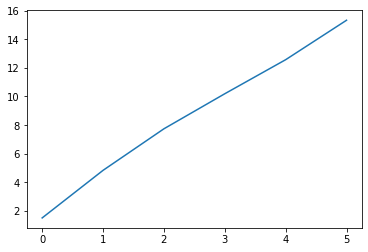

In [16]:
num_grid_points = 5
grid_bounds = [0,5]
diffusivity = 2
A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points, grid_bounds,[1.5],[3],'Dirichlet','Neumann')
def source_func(x,u,mu):
    return np.sin(x)
solution, xvals = finite_diff_bvp_solver(num_grid_points, diffusivity,grid_bounds, A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val, source_func)
plt.plot(xvals,solution)

need xvalsinterior
left_dirichlet_val
right_dirichlet val
both passed can construct x_interior